## Assessment of Quality of Chat Support Logs Using Text Mining, Sentiment Analysis, Natural Language Processing, & LSTM-RNN Algo's

In [218]:
#Required if importing like this: from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
#pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [75]:
# Python Libraries
import pandas as pd
import numpy as np
from collections import Counter 

#For Data balancing
from imblearn.over_sampling import SMOTE

#visualization
import seaborn as sns

# NLP processing
import re # For regular expression
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords, opinion_lexicon
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Train and Test splitting of Data
from sklearn.model_selection import train_test_split

# Model Building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling


In [23]:
chat_data= pd.read_csv('sample.csv')

In [24]:
chat_data.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,119237,105834,True,Wed Oct 11 06:55:44 +0000 2017,@AppleSupport causing the reply to be disregar...,119236,NaN
1,119238,ChaseSupport,False,Wed Oct 11 13:25:49 +0000 2017,@105835 Your business means a lot to us. Pleas...,NaN,119239.0
2,119239,105835,True,Wed Oct 11 13:00:09 +0000 2017,@76328 I really hope you all change but I'm su...,119238,NaN
3,119240,VirginTrains,False,Tue Oct 10 15:16:08 +0000 2017,@105836 LiveChat is online at the moment - htt...,119241,119242.0
4,119241,105836,True,Tue Oct 10 15:17:21 +0000 2017,@VirginTrains see attached error message. I've...,119243,119240.0


In [25]:
chat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tweet_id                 93 non-null     int64  
 1   author_id                93 non-null     object 
 2   inbound                  93 non-null     bool   
 3   created_at               93 non-null     object 
 4   text                     93 non-null     object 
 5   response_tweet_id        65 non-null     object 
 6   in_response_to_tweet_id  68 non-null     float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 4.6+ KB


In [26]:
chat_data.describe()

,tweet_id,in_response_to_tweet_id
count,93.000000,68.000000
mean,119285.451613,119285.676471
std,28.314045,28.910795
min,119237.000000,119239.000000
25%,119262.000000,119259.750000
50%,119285.000000,119284.500000
75%,119309.000000,119311.500000
max,119335.000000,119334.000000


In [27]:
chat_data.describe(include='all')

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
count,93.000000,93,93,93,93,65,68.000000
unique,NaN,42,2,93,93,65,NaN
top,NaN,AppleSupport,True,Wed Oct 11 06:55:44 +0000 2017,@AppleSupport causing the reply to be disregar...,119236,NaN
freq,NaN,13,49,1,1,1,NaN
mean,119285.451613,NaN,NaN,NaN,NaN,NaN,119285.676471
std,28.314045,NaN,NaN,NaN,NaN,NaN,28.910795
min,119237.000000,NaN,NaN,NaN,NaN,NaN,119239.000000
25%,119262.000000,NaN,NaN,NaN,NaN,NaN,119259.750000
50%,119285.000000,NaN,NaN,NaN,NaN,NaN,119284.500000
75%,119309.000000,NaN,NaN,NaN,NaN,NaN,119311.500000


In [28]:
chat_data.shape

(93, 7)

# Pre Processing

lowercasing, stopwords removal, stemming, removing urls, HTML tags, Abbreviation, emoticons, emojis

In [29]:
#lower case conversion
chat_data['text_lower'] = chat_data.loc[:,'text'].str.lower()
chat_data.loc[:,['text','text_lower']]
#chat_data.iloc[:,[2,3]]

,text,text_lower
0,@AppleSupport causing the reply to be disregar...,@applesupport causing the reply to be disregar...
1,@105835 Your business means a lot to us. Pleas...,@105835 your business means a lot to us. pleas...
2,@76328 I really hope you all change but I'm su...,@76328 i really hope you all change but i'm su...
3,@105836 LiveChat is online at the moment - htt...,@105836 livechat is online at the moment - htt...
4,@VirginTrains see attached error message. I've...,@virgintrains see attached error message. i've...
...,...,...
88,@105860 I wish Amazon had an option of where I...,@105860 i wish amazon had an option of where i...
89,They reschedule my shit for tomorrow https://t...,they reschedule my shit for tomorrow https://t...
90,"@105861 Hey Sara, sorry to hear of the issues ...","@105861 hey sara, sorry to hear of the issues ..."
91,@Tesco bit of both - finding the layout cumber...,@tesco bit of both - finding the layout cumber...


In [30]:
# Remove Punctuation
import string
punctuations = string.punctuation
print(punctuations)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [31]:
only_text = chat_data['text_lower']

print(only_text)

0     @applesupport causing the reply to be disregar...
1     @105835 your business means a lot to us. pleas...
2     @76328 i really hope you all change but i'm su...
3     @105836 livechat is online at the moment - htt...
4     @virgintrains see attached error message. i've...
                            ...                        
88    @105860 i wish amazon had an option of where i...
89    they reschedule my shit for tomorrow https://t...
90    @105861 hey sara, sorry to hear of the issues ...
91    @tesco bit of both - finding the layout cumber...
92    @105861 if that doesn't help please dm your fu...
Name: text_lower, Length: 93, dtype: object


In [32]:
#Method 1: For removing punctuations.

# for word in only_text:
#     for w in word:
#         if w in punctuations:
#             w = w.replace(w,'')
#     print (w)

In [34]:
# Method 2: Not working
# res=pd.DataFrame()
# def remove_p(text):
#    # for 
#     print("Text is:", text)
#     return re.sub(r"[!\"#$%&'()*+-,./:;<=>?@[\]^_`{|}~]",'',text,count=0,flags=0)
#     #print (res) 

# #chat_data['wo_punc1'] =
# res['i']=only_text.apply(lambda x: remove_p(text))
# #print (res) 
# #chat_data['wo_punc1'] 
# #error:1. multiple repeat at position 10, 2. same text
# # Solution 1. : 

In [38]:
!pip install clean-text

Note: you may need to restart the kernel to use updated packages.


In [40]:
#Method 3: Most Useful
import string
from cleantext import clean

punctuations= string.punctuation
url_pattern = r'http://\S+|https://\S+'

nltk.download('stopwords')
stopwords_set = set(stopwords.words('english'))

def CleanText(text):
    newstr= re.sub(url_pattern,'',text) # removing urls
    newstr= newstr.translate(str.maketrans('','',punctuations)) # removing punctuations
    newstr = newstr.lstrip() # removing whitespaces from left
    newstr = clean(newstr,no_emoji=True) # removing Emojis, Removing unicode characters
    newstr= re.sub(r'[0-9]','',newstr,count=0,flags=0) # removing digits 
    newstr= list(filter((lambda x: x not in stopwords_set), newstr.split())) #Removing Stopwords
    return newstr #returning the final string 

#Applying CleanText function to the lower text column of the dataframe
chat_data['wo_punc'] = only_text.apply(lambda row: CleanText(row)) 
chat_data['wo_punc'].head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shilp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    [applesupport, causing, reply, disregarded, ta...
1    [business, means, lot, us, please, dm, name, z...
2         [really, hope, change, im, sure, wont, dont]
3    [livechat, online, moment, contact, option, le...
4    [virgintrains, see, attached, error, message, ...
Name: wo_punc, dtype: object

In [ ]:
# Method 4: Fast but useful when we need to tokenize URLs , numbers etc.
# from cleantext import clean

# def fun_clean(text):
#     newstr = clean(text,
#                no_emoji=True,
#                no_punct=True,
#                no_urls=True,
#                no_numbers=True,
#                no_digits=False,
#                fix_unicode=True)
#     return newstr
# #chat_data['clean'] = only_text.apply(lambda x:fun_clean(x))
# #chat_data['clean']

#### Removing Frequent words

In [41]:
# Finding frequent words
cnt=Counter()
for words in chat_data['wo_punc'].values:
    for w in words:
        cnt[w]=cnt[w] + 1

Top20_Freq_Words = cnt.most_common(20)
print(Top20_Freq_Words)

[('us', 25), ('dm', 19), ('help', 18), ('thanks', 13), ('applesupport', 11), ('please', 11), ('phone', 9), ('hi', 9), ('ive', 8), ('version', 8), ('ios', 8), ('get', 8), ('tesco', 8), ('device', 7), ('look', 7), ('let', 7), ('using', 7), ('spotifycares', 7), ('back', 6), ('tried', 6)]


In [42]:
# function to remove Frequent words
def remove_freqwords(text):
    return ' '.join(words for words in text if words not in Top20_Freq_Words)

chat_data['text_wo_freq'] = chat_data['wo_punc'].apply(lambda x: remove_freqwords(x))
chat_data['text_wo_freq']

0     applesupport causing reply disregarded tapped ...
1     business means lot us please dm name zip code ...
2                  really hope change im sure wont dont
3     livechat online moment contact option leave me...
4     virgintrains see attached error message ive tr...
                            ...                        
88    wish amazon option get shipped ups store avoid...
89                             reschedule shit tomorrow
90    hey sara sorry hear issues ask lay speed websi...
91    tesco bit finding layout cumbersome removing i...
92    doesnt help please dm full name address email ...
Name: text_wo_freq, Length: 93, dtype: object

In [43]:
# testing pos_tag by taking a single row of data
li1= chat_data['wo_punc'][1]
print(nltk.pos_tag(li1))

[('business', 'NN'), ('means', 'NNS'), ('lot', 'VBP'), ('us', 'PRP'), ('please', 'VB'), ('dm', 'JJ'), ('name', 'NN'), ('zip', 'NN'), ('code', 'NN'), ('additional', 'JJ'), ('details', 'NNS'), ('concern', 'NN'), ('rr', 'NN')]


## Lemmatization

In [47]:
lem = WordNetLemmatizer()
#words = nltk.tokenize.word_tokenize()

wordnet_map = {"N":wordnet.NOUN,"V":wordnet.VERB,"J":wordnet.ADJ,"R":wordnet.ADV}
def fun_lemmatization(text):
    string =''
   # print(text)
    pos_tagged_text = nltk.pos_tag(text)
    for words,pos in pos_tagged_text:
 #       print(words)
        word = lem.lemmatize(words,wordnet_map.get(pos[0],wordnet.NOUN))
       # print(word)
        string = string + word + " "
       # print(string)
    return string

chat_data['text_after_lem'] = chat_data['wo_punc'].apply(lambda x: fun_lemmatization(x)) 
chat_data['text_after_lem'][1]


'business mean lot u please dm name zip code additional detail concern rr '

In [211]:
chat_data

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,text_lower,clean,wo_punc,text_wo_freq,text_after_lem
0,119237,105834,True,Wed Oct 11 06:55:44 +0000 2017,@AppleSupport causing the reply to be disregar...,119236,NaN,@applesupport causing the reply to be disregar...,applesupport causing the reply to be disregard...,"[applesupport, causing, reply, disregarded, ta...",applesupport causing reply disregarded tapped ...,applesupport cause reply disregard tapped no...
1,119238,ChaseSupport,False,Wed Oct 11 13:25:49 +0000 2017,@105835 Your business means a lot to us. Pleas...,NaN,119239.0,@105835 your business means a lot to us. pleas...,<number> your business means a lot to us pleas...,"[business, means, lot, us, please, dm, name, z...",business means lot us please dm name zip code ...,business mean lot u please dm name zip code ...
2,119239,105835,True,Wed Oct 11 13:00:09 +0000 2017,@76328 I really hope you all change but I'm su...,119238,NaN,@76328 i really hope you all change but i'm su...,<number> i really hope you all change but im s...,"[really, hope, change, im, sure, wont, dont]",really hope change im sure wont dont,really hope change im sure wont dont
3,119240,VirginTrains,False,Tue Oct 10 15:16:08 +0000 2017,@105836 LiveChat is online at the moment - htt...,119241,119242.0,@105836 livechat is online at the moment - htt...,<number> livechat is online at the moment <url...,"[livechat, online, moment, contact, option, le...",livechat online moment contact option leave me...,livechat online moment contact option leave ...
4,119241,105836,True,Tue Oct 10 15:17:21 +0000 2017,@VirginTrains see attached error message. I've...,119243,119240.0,@virgintrains see attached error message. i've...,virgintrains see attached error message ive tr...,"[virgintrains, see, attached, error, message, ...",virgintrains see attached error message ive tr...,virgintrains see attach error message ive tr...
...,...,...,...,...,...,...,...,...,...,...,...,...
88,119330,105859,True,Wed Oct 11 13:50:42 +0000 2017,@105860 I wish Amazon had an option of where I...,119329,119331.0,@105860 i wish amazon had an option of where i...,<number> i wish amazon had an option of where ...,"[wish, amazon, option, get, shipped, ups, stor...",wish amazon option get shipped ups store avoid...,wish amazon option get ship ups store avoid ...
89,119331,105860,True,Wed Oct 11 13:47:14 +0000 2017,They reschedule my shit for tomorrow https://t...,119330,NaN,they reschedule my shit for tomorrow https://t...,they reschedule my shit for tomorrow <url>,"[reschedule, shit, tomorrow]",reschedule shit tomorrow,reschedule shit tomorrow
90,119332,Tesco,False,Wed Oct 11 13:34:06 +0000 2017,"@105861 Hey Sara, sorry to hear of the issues ...",119333,119334.0,"@105861 hey sara, sorry to hear of the issues ...",<number> hey sara sorry to hear of the issues ...,"[hey, sara, sorry, hear, issues, ask, lay, spe...",hey sara sorry hear issues ask lay speed websi...,hey sara sorry hear issue ask lay speed webs...
91,119333,105861,True,Wed Oct 11 14:05:18 +0000 2017,@Tesco bit of both - finding the layout cumber...,"119335,119336",119332.0,@tesco bit of both - finding the layout cumber...,tesco bit of both finding the layout cumbersom...,"[tesco, bit, finding, layout, cumbersome, remo...",tesco bit finding layout cumbersome removing i...,tesco bit find layout cumbersome remove item...


In [48]:
chat_data= chat_data.drop(columns = ['tweet_id','author_id','created_at','response_tweet_id','in_response_to_tweet_id'])

## Sentiment Scoring

In [49]:
# Required, otherwise Error while using SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\shilp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [50]:
sentiment = SentimentIntensityAnalyzer()

def vader_scores(dataset, column):
    sentiment = SentimentIntensityAnalyzer()
    dataset["vader_neg"] = dataset[column].apply(lambda x: sentiment.polarity_scores(x)['neg'])
    dataset["vader_pos"] = dataset[column].apply(lambda x: sentiment.polarity_scores(x)['pos'])
    dataset['vader_neu'] = dataset[column].apply(lambda x: sentiment.polarity_scores(x)['neu'])
    dataset['vader_compound'] = dataset[column].apply(lambda x: sentiment.polarity_scores(x)['compound'])
    return dataset

df2 = vader_scores(chat_data,'text_after_lem')
df2

,inbound,text,text_lower,wo_punc,text_wo_freq,text_after_lem,vader_neg,vader_pos,vader_neu,vader_compound
0,True,@AppleSupport causing the reply to be disregar...,@applesupport causing the reply to be disregar...,"[applesupport, causing, reply, disregarded, ta...",applesupport causing reply disregarded tapped ...,applesupport cause reply disregard tapped noti...,0.231,0.000,0.769,-0.2732
1,False,@105835 Your business means a lot to us. Pleas...,@105835 your business means a lot to us. pleas...,"[business, means, lot, us, please, dm, name, z...",business means lot us please dm name zip code ...,business mean lot u please dm name zip code ad...,0.000,0.173,0.827,0.3182
2,True,@76328 I really hope you all change but I'm su...,@76328 i really hope you all change but i'm su...,"[really, hope, change, im, sure, wont, dont]",really hope change im sure wont dont,really hope change im sure wont dont,0.000,0.523,0.477,0.6697
3,False,@105836 LiveChat is online at the moment - htt...,@105836 livechat is online at the moment - htt...,"[livechat, online, moment, contact, option, le...",livechat online moment contact option leave me...,livechat online moment contact option leave me...,0.118,0.000,0.882,-0.0516
4,True,@VirginTrains see attached error message. I've...,@virgintrains see attached error message. i've...,"[virgintrains, see, attached, error, message, ...",virgintrains see attached error message ive tr...,virgintrains see attach error message ive try ...,0.262,0.000,0.738,-0.4404
...,...,...,...,...,...,...,...,...,...,...
88,True,@105860 I wish Amazon had an option of where I...,@105860 i wish amazon had an option of where i...,"[wish, amazon, option, get, shipped, ups, stor...",wish amazon option get shipped ups store avoid...,wish amazon option get ship ups store avoid lo...,0.302,0.295,0.403,-0.0258
89,True,They reschedule my shit for tomorrow https://t...,they reschedule my shit for tomorrow https://t...,"[reschedule, shit, tomorrow]",reschedule shit tomorrow,reschedule shit tomorrow,0.643,0.000,0.357,-0.5574
90,False,"@105861 Hey Sara, sorry to hear of the issues ...","@105861 hey sara, sorry to hear of the issues ...","[hey, sara, sorry, hear, issues, ask, lay, spe...",hey sara sorry hear issues ask lay speed websi...,hey sara sorry hear issue ask lay speed websit...,0.094,0.187,0.719,0.3182
91,True,@Tesco bit of both - finding the layout cumber...,@tesco bit of both - finding the layout cumber...,"[tesco, bit, finding, layout, cumbersome, remo...",tesco bit finding layout cumbersome removing i...,tesco bit find layout cumbersome remove item f...,0.000,0.270,0.730,0.5859


In [51]:

def sentiment(dataset):
    if(dataset['vader_compound'] > 0.05): #if Score is greater than 5%
#    if(sentence > 0.05)
        return "positive"
    elif(dataset['vader_compound'] < -0.05): #if Score is less than -5%
        return "negative"
    elif (-0.05 <=dataset['vader_compound'] <=0.05): #if Score is between -5% and 5%
        return "neutral"
    else:
        return "check"
chat_data.apply(sentiment())
#chat_data['sentiment'] =    
#chat_data['sentiment'] = chat_data['compound'].apply(lambda x: sentiment(x))
chat_data['sentiment']

TypeError: sentiment() missing 1 required positional argument: 'dataset'

In [56]:
def sentiment(score):
    if(score > 0.05): #if Score is greater than 5%
#    if(sentence > 0.05)
        return "positive"
    elif(score < -0.05): #if Score is less than -5%
        return "negative"
    elif (-0.05 <=score <=0.05): #if Score is between -5% and 5%
        return "neutral"
    else:
        return "check"
    
chat_data['sentiment'] = chat_data['vader_compound'].apply(lambda x: sentiment(x))  
chat_data

,inbound,text,text_lower,wo_punc,text_wo_freq,text_after_lem,vader_neg,vader_pos,vader_neu,vader_compound,sentiment
0,True,@AppleSupport causing the reply to be disregar...,@applesupport causing the reply to be disregar...,"[applesupport, causing, reply, disregarded, ta...",applesupport causing reply disregarded tapped ...,applesupport cause reply disregard tapped noti...,0.231,0.000,0.769,-0.2732,negative
1,False,@105835 Your business means a lot to us. Pleas...,@105835 your business means a lot to us. pleas...,"[business, means, lot, us, please, dm, name, z...",business means lot us please dm name zip code ...,business mean lot u please dm name zip code ad...,0.000,0.173,0.827,0.3182,positive
2,True,@76328 I really hope you all change but I'm su...,@76328 i really hope you all change but i'm su...,"[really, hope, change, im, sure, wont, dont]",really hope change im sure wont dont,really hope change im sure wont dont,0.000,0.523,0.477,0.6697,positive
3,False,@105836 LiveChat is online at the moment - htt...,@105836 livechat is online at the moment - htt...,"[livechat, online, moment, contact, option, le...",livechat online moment contact option leave me...,livechat online moment contact option leave me...,0.118,0.000,0.882,-0.0516,negative
4,True,@VirginTrains see attached error message. I've...,@virgintrains see attached error message. i've...,"[virgintrains, see, attached, error, message, ...",virgintrains see attached error message ive tr...,virgintrains see attach error message ive try ...,0.262,0.000,0.738,-0.4404,negative
...,...,...,...,...,...,...,...,...,...,...,...
88,True,@105860 I wish Amazon had an option of where I...,@105860 i wish amazon had an option of where i...,"[wish, amazon, option, get, shipped, ups, stor...",wish amazon option get shipped ups store avoid...,wish amazon option get ship ups store avoid lo...,0.302,0.295,0.403,-0.0258,neutral
89,True,They reschedule my shit for tomorrow https://t...,they reschedule my shit for tomorrow https://t...,"[reschedule, shit, tomorrow]",reschedule shit tomorrow,reschedule shit tomorrow,0.643,0.000,0.357,-0.5574,negative
90,False,"@105861 Hey Sara, sorry to hear of the issues ...","@105861 hey sara, sorry to hear of the issues ...","[hey, sara, sorry, hear, issues, ask, lay, spe...",hey sara sorry hear issues ask lay speed websi...,hey sara sorry hear issue ask lay speed websit...,0.094,0.187,0.719,0.3182,positive
91,True,@Tesco bit of both - finding the layout cumber...,@tesco bit of both - finding the layout cumber...,"[tesco, bit, finding, layout, cumbersome, remo...",tesco bit finding layout cumbersome removing i...,tesco bit find layout cumbersome remove item f...,0.000,0.270,0.730,0.5859,positive


# Plotting sentiments

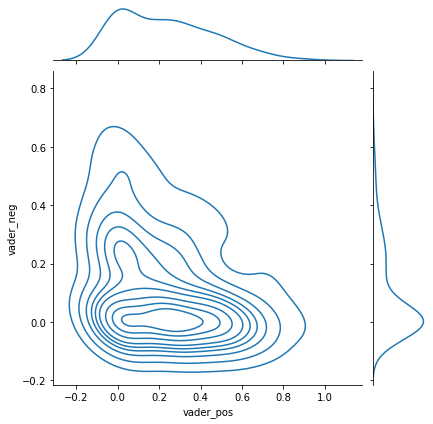

In [52]:
# why jointplot
sns.jointplot(data=chat_data, x='vader_pos',y='vader_neg',kind='kde')


<AxesSubplot:xlabel='sentiment', ylabel='count'>

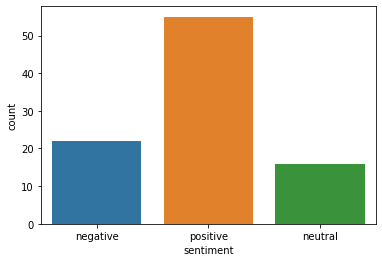

In [57]:
sns.countplot(data=chat_data,x='sentiment')

In [68]:
chat_data.sentiment.value_counts(normalize=True)

positive    0.591398
negative    0.236559
neutral     0.172043
Name: sentiment, dtype: float64

In [58]:
chat_data.columns

Index(['inbound', 'text', 'text_lower', 'wo_punc', 'text_wo_freq',
       'text_after_lem', 'vader_neg', 'vader_pos', 'vader_neu',
       'vader_compound', 'sentiment'],
      dtype='object')

In [63]:
ready_chat_data = chat_data[['text_after_lem','sentiment']]
target =  chat_data['sentiment']
feature = chat_data['text_after_lem']

# TFIDF

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(feature)

## Train Test split

In [69]:
x_train, x_test,y_train,y_test = train_test_split(x,target,test_size=.30)

C:\Users\shilp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

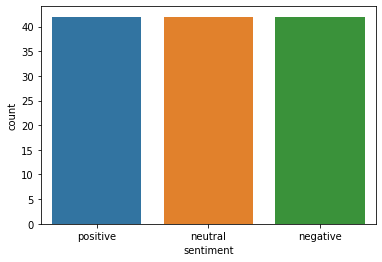

In [71]:
#Oversampling the train data
smote = SMOTE()

x_sm,y_sm = smote.fit_resample(x_train,y_train)
sns.countplot(y_sm)

In [91]:
word_list=[]
max_len=50
max_words = 5000

def token_pad_sequences(dataset):
    texts = dataset
    token = Tokenizer(num_words=max_words, oov_token='[oov]', split=' ')
    token.fit_on_texts(texts)
    X= token.texts_to_sequences(texts)
    X= pad_sequences(X, padding='post',maxlen=max_len)
    return X, token


print("before padding sequence: \n",feature[0])
X,token = token_pad_sequences(feature) # calling user-defined funciton above

print("\nAfter pading sequence",X[0])
print(X.shape)

before padding sequence: 
 applesupport cause reply disregard tapped notification keyboard open 

After pading sequence [  7  61  41 178 179 180 181 182   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
(93, 50)


In [94]:
y = pd.get_dummies(target)
print(y)

    negative  neutral  positive
0          1        0         0
1          0        0         1
2          0        0         1
3          1        0         0
4          1        0         0
..       ...      ...       ...
88         0        1         0
89         1        0         0
90         0        0         1
91         0        0         1
92         1        0         0

[93 rows x 3 columns]


# Modeling

In [ ]:
from tensorflow.keras.models import Sequential

model=Sequential()
